# Pre-process

## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt
import random
import time

import json
import os.path
import gc

from script.module.FeatureProducer import FeatureProducer 
from script.module.LightFMProducer import LightFMProducer
MODEL_FILE_NAME = 'model.txt'

In [2]:
def custom_cv(params, train_set, hold_out_set=None, k_fold=5, num_boost_round=20):
    x_train = train_set.data
    y_train = train_set.label
    n = x_train.shape[0]
    unit = n // k_fold

    cv_scores = []
    for k in range(k_fold):
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if k < k_fold - 1:
            continue
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_cv_valid = None
        y_cv_valid = None
        if k == k_fold - 1:
            x_cv_valid = x_train[unit * k:]
            y_cv_valid = y_train[unit * k:]
        else:
            x_cv_valid = x_train[unit * k: unit * (k + 1)]
            y_cv_valid = y_train[unit * k: unit * (k + 1)]

        x_cv_train = None
        y_cv_train = None
        if k == 0:
            x_cv_train = x_train[unit * (k + 1):]
            y_cv_train = y_train[unit * (k + 1):]
        elif k == k_fold - 1:
            x_cv_train = x_train[:unit * k]
            y_cv_train = y_train[:unit * k]
        else:
            x_cv_train = x_train[:unit * k].append(x_train[unit * (k + 1):])
            y_cv_train = y_train[:unit * k].append(y_train[unit * (k + 1):])

        cv_train_set = lgb.Dataset(x_cv_train, y_cv_train)
        cv_valid_set = lgb.Dataset(x_cv_valid, y_cv_valid)
        watchlist = [cv_valid_set]

        # not tested yet
        if hold_out_set is not None:
            watchlist.append(hold_out_set)
        model = lgb.train(params, train_set=cv_train_set, valid_sets=watchlist,
                          num_boost_round=num_boost_round, verbose_eval=5)
        print(model.best_score)
        cv_scores.append(model.best_score['valid_1']['auc'])

    tip_txt = '[CV]'
    tip_txt += ' ' + str(cv_scores)
    mean_cv_score = np.mean(cv_scores)
    tip_txt += '{ auc score=' + str(mean_cv_score) + ' }'
    print(tip_txt)

    return mean_cv_score

In [3]:
def custom_grid_search(params, own_grid_params, train_set, valid_set, num_boost_round=20):
    keys = []
    values = [list()]
    for key, value in own_grid_params.items():
        keys.append(key)
        new_values = []
        for item in values:
            for val in value:
                new_values.append(item + [val])
        values = new_values

    watchlist = [valid_set]
    grid_best_params = None
    grid_best_score = None

    for comb in values:
        own_params = {}
        for idx in range(len(keys)):
            own_params[keys[idx]] = comb[idx]
            params[keys[idx]] = comb[idx]

        cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=num_boost_round)

        tip_txt = '[GridSearch]'
        for idx in range(len(keys)):
            tip_txt += ' ' + str(keys[idx]) + '=' + str(comb[idx])
        tip_txt += ' { best_score: ' + str(cv_score) + ' }'
        print(tip_txt)

        if grid_best_score is None or cv_score > grid_best_score:
            grid_best_params, grid_best_score = own_params, cv_score

    tip_txt = '[GS Best Result]'
    for key, val in grid_best_params.items():
        tip_txt += ' ' + str(key) + '=' + str(val)
    tip_txt += ' { best_score: ' + str(grid_best_score) + ' }'
    print(tip_txt)
    
    return grid_best_params

## init

In [4]:
fp = FeatureProducer(root='./data')

## load

In [5]:
fp.load_raw()

18:27:22 INFO << load raw data in 19.34s


## preprocess

In [6]:
fp.pre_process()

18:27:50 INFO << parse train_df in 28.96s
18:28:06 INFO << parse test_df in 15.49s
18:28:07 INFO << parse members_df in 0.89s
18:28:24 INFO << parse songs_df in 16.32s
18:28:27 INFO << parse song_extra_info_df in 2.98s


## feature engineering

In [7]:
fp.feature_engineering()

18:29:14 INFO << parse engineering_df in 23.04s
18:29:32 INFO << parse engineering_df in 18.77s


## type to category

In [8]:
fp.self_fit_transform()

18:29:48 INFO << transform "msno" in 2.05s
18:29:51 INFO << transform "song_id" in 3.63s
18:29:53 INFO << transform "source_system_tab" in 1.14s
18:29:54 INFO << transform "source_screen_name" in 1.19s
18:29:55 INFO << transform "source_type" in 1.11s
18:29:55 INFO << transform "1h_source" in 0.40s
18:29:56 INFO << transform "1h_system_tab" in 0.38s
18:29:56 INFO << transform "1h_screen_name" in 0.35s
18:29:56 INFO << transform "1h_source_type" in 0.32s
18:29:57 INFO << transform "song_length" in 0.29s
18:29:58 INFO << transform "genre_ids" in 1.24s
18:29:59 INFO << transform "artist_name" in 1.56s
18:30:01 INFO << transform "composer" in 1.42s
18:30:02 INFO << transform "lyricist" in 1.11s
18:30:03 INFO << transform "language" in 1.09s
18:30:03 INFO << transform "artist_count" in 0.27s
18:30:04 INFO << transform "genre_count" in 0.24s
18:30:04 INFO << transform "composer_count" in 0.22s
18:30:04 INFO << transform "lyricist_count" in 0.19s
18:30:04 INFO << transform "1h_lang" in 0.14s


## CF natively

In [9]:
%%cache
lp = LightFMProducer(root='./data', num_components=1) 
lp.prepare()
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

18:30:07 ERROR << Cell magic `%%cache` not found.


In [10]:
%%cache
train_cf_df = lp.compute(True)
test_cf_df = lp.compute(False)

18:30:07 ERROR << Cell magic `%%cache` not found.


In [11]:
%%cache
train_cf_df.drop(['msno', 'song_id', 'genre_ids', 'target'], axis=1, inplace=True)
test_cf_df.drop(['msno', 'song_id', 'genre_ids'], axis=1, inplace=True)

18:30:08 ERROR << Cell magic `%%cache` not found.


In [12]:
train_df = fp.train_df
test_df = fp.test_df

assert(train_df.shape[1] == test_df.shape[1])

In [13]:
%%cache
train_df = train_df.join(train_cf_df)
test_df = test_df.join(test_cf_df)

18:30:08 ERROR << Cell magic `%%cache` not found.


In [14]:
%%cache
train_df.drop(['genre_ids'], axis=1, inplace=True)
test_df.drop(['genre_ids'], axis=1, inplace=True)

print(train_df.info())
print(test_df.info())

18:30:08 ERROR << Cell magic `%%cache` not found.


# LGBM training

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

In [15]:
# corr = train_df.corr()
# 
# f, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax)
# plt.show()

## Prepare

In [16]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

# take the last # rows of train_df as valid set where # means number of rows in test_df
x_valid = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y_valid = train_df['target'].tail(test_df.shape[0])

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id']

In [17]:
train_df.head(15)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,1h_source,1h_system_tab,1h_screen_name,1h_source_type,...,membership_days,registration_init_year,registration_init_month,expiration_date_year,expiration_date_month,1h_via,play_count,track_count,cover_lang,timestamp
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,False,False,False,False,...,2103,2012,1,2017,10,True,215,84,1,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,2301,2011,5,2017,9,True,1,17080,10,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,2301,2011,5,2017,9,True,4,61,2,2
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,2301,2011,5,2017,9,True,1,1,1,3
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,False,False,False,False,...,2103,2012,1,2017,10,True,412,6,1,4
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,False,False,False,False,...,2103,2012,1,2017,10,True,1108,15,1,5
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,True,True,True,True,...,2301,2011,5,2017,9,True,3869,43,1,6
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,False,False,False,False,...,2103,2012,1,2017,10,True,287,33,1,7
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,True,True,True,True,...,2309,2011,11,2018,3,True,31,155,2,8
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,True,True,True,True,...,2309,2011,11,2018,3,True,738,155,2,9


In [18]:
test_df.head(15)

,id,msno,song_id,source_system_tab,source_screen_name,source_type,1h_source,1h_system_tab,1h_screen_name,1h_source_type,...,membership_days,registration_init_year,registration_init_month,expiration_date_year,expiration_date_month,1h_via,play_count,track_count,cover_lang,timestamp
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,True,True,True,True,...,577,2016,2,2017,9,True,890,85,1,7377418
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,True,True,True,True,...,577,2016,2,2017,9,True,7569,277,3,7377419
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,others,song-based-playlist,False,False,False,False,...,7,2016,11,2016,11,False,7,63,1,7377420
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,False,False,False,False,...,3567,2007,7,2017,4,True,45,105,2,7377421
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,False,False,False,False,...,3567,2007,7,2017,4,True,8,25,1,7377422
5,5,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,NV3nhEcMqsawwvSNTUAt9IVAexHLOm0lDfrHyEfN5B0=,radio,Radio,radio,False,False,False,False,...,3567,2007,7,2017,4,True,110,35,1,7377423
6,6,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,DPM6G9RB5QO2dvAVPyc70gxHdvu872IjTUvV6LJT8ho=,radio,Radio,radio,False,False,False,False,...,3567,2007,7,2017,4,True,146,220,3,7377424
7,7,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,JGXB3PHc0CX0JskwwjmYP8i318BLo7DhChgEj6Yqjt8=,my library,Local playlist more,local-playlist,True,True,True,True,...,3567,2007,7,2017,4,True,1269,139,1,7377425
8,8,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,507plIkmke1jh3wMrHqKore82pPFozADwydR8P0Gx2Q=,radio,Radio,radio,False,False,False,False,...,3567,2007,7,2017,4,True,1089,37,2,7377426
9,9,3ZQ6oGfcSiUoCrtBPKGa8hHCiFh5jqtDqPVDUl/zrjU=,HsgJXv1C7iVZiP7CWwWTfsmMhia6Huc0MUccfj+D02o=,my library,Local playlist more,local-library,True,True,True,True,...,639,2015,12,2017,9,True,3032,191,5,7377427


## Core

In [19]:
train_set = lgb.Dataset(x, y)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'learning_rate': 0.2,
    'application': 'binary',
    'min_data_in_leaf': 10,
#    'max_depth': 10,
    'num_leaves': 2 ** 7,
    'max_bin': 255,
    'verbosity': 0,
    'metric': 'auc'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

# best_grid_params = custom_grid_search(params, grid_params, train_set, hold_out_set, num_boost_round=20)
# for key, val in best_grid_params.items():
#     params[key] = best_grid_params[key]

cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=200)
print(cv_score)

model = lgb.train(params, train_set=train_set, valid_sets=watchlist, num_boost_round=200, verbose_eval=5)
y_test = model.predict(x_test)

# When CV, valid_0 means the front 75% training, the last 25% validating
#          valid_1 means the front 75% training, the last "len(test set)" validating
#
# When LGBM running, valid_0 means 100% training, the last "len(test set)" validating.
#
# Use CV valid_0 auc score to predict result!

[5]	valid_0's auc: 0.651836	valid_1's auc: 0.670162
[10]	valid_0's auc: 0.662421	valid_1's auc: 0.684541
[15]	valid_0's auc: 0.669345	valid_1's auc: 0.694416
[20]	valid_0's auc: 0.674894	valid_1's auc: 0.702435
[25]	valid_0's auc: 0.677111	valid_1's auc: 0.70686
[30]	valid_0's auc: 0.679278	valid_1's auc: 0.711501
[35]	valid_0's auc: 0.680461	valid_1's auc: 0.715676
[40]	valid_0's auc: 0.680805	valid_1's auc: 0.717606
[45]	valid_0's auc: 0.680507	valid_1's auc: 0.719346
[50]	valid_0's auc: 0.680591	valid_1's auc: 0.72053
[55]	valid_0's auc: 0.679694	valid_1's auc: 0.72196
[60]	valid_0's auc: 0.678976	valid_1's auc: 0.722695
[65]	valid_0's auc: 0.67927	valid_1's auc: 0.723709
[70]	valid_0's auc: 0.679189	valid_1's auc: 0.724197
[75]	valid_0's auc: 0.678216	valid_1's auc: 0.724716
[80]	valid_0's auc: 0.678461	valid_1's auc: 0.725374
[85]	valid_0's auc: 0.678144	valid_1's auc: 0.725833
[90]	valid_0's auc: 0.678154	valid_1's auc: 0.726294
[95]	valid_0's auc: 0.678055	valid_1's auc: 0.72661

## Feature importances

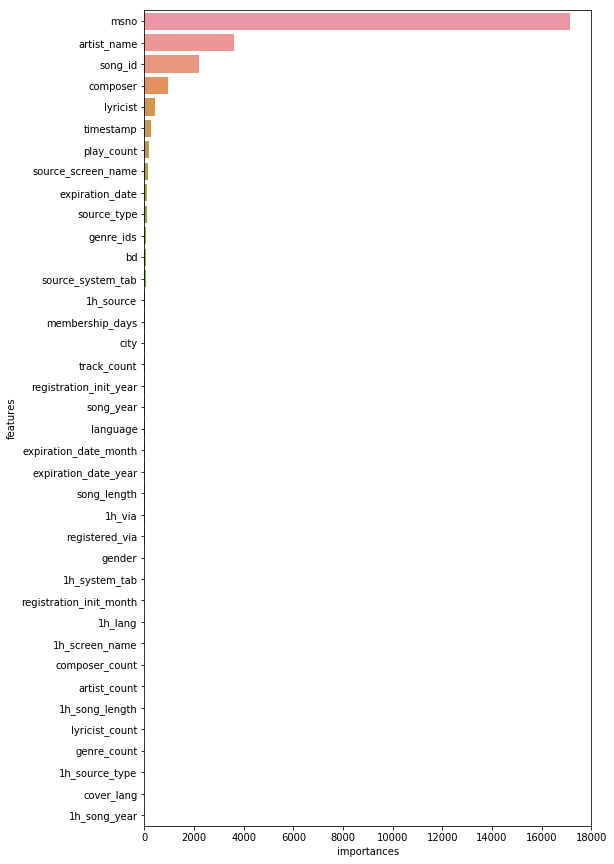

In [20]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

## Output

In [21]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
# string file compression reduces file size
submission_df.to_csv('data/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        int64
target    float64
dtypes: float64(1), int64(1)
memory usage: 58.5 MB
